# Example of Interactive Plotting

The IPython notebook excels at interactive science. By its very nature you can easily create a bit of code, run it, look at the output, and adjust the code. This allows you to do very rapid development and work you way through a problem while documenting you thought process. As an example, I am going simulate some data and do some interactive plotting.

In [5]:
# Import Module
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

## Simulate data
I am going to simulate data using the various density functions available in scipy. During QC, we typically are trying to identify either samples or values (e.g. genes, exons, compounds) that do not behave as expected. We use various plots to help identify outliers and remove them from the dataset.

For this example I am going to simulate a value $\theta$. Here I expect $\theta$ to be normally distributed around 0.5, however I include some **bad** values that are normally distributed around 0.2. I am relating these **bad** values to another variable *coverage*. When *coverage* is low then we will not accurately capture $\theta$ causing a shift in the distribution of values.

In [6]:
# Simulate $\theta$
sp.random.seed(42)
theta1 = sp.random.normal(loc=0.5, scale=0.1, size=1000)
theta2 = sp.random.normal(loc=0.2, scale=0.1, size=360)

# Simulate coverage
cvg1 = sp.random.poisson(20, size=1000)
cvg2 = sp.random.poisson(4, size=360)

## I can't have a coverage of 0, so replace 0's with 1
cvg1[cvg1 == 0] = 1
cvg2[cvg2 == 0] = 1

## Create joint of theta1 and theat2
theta = np.concatenate((theta1, theta2))

## Create joint of cvg1 and cvg2
cvg = np.concatenate((cvg1, cvg2))

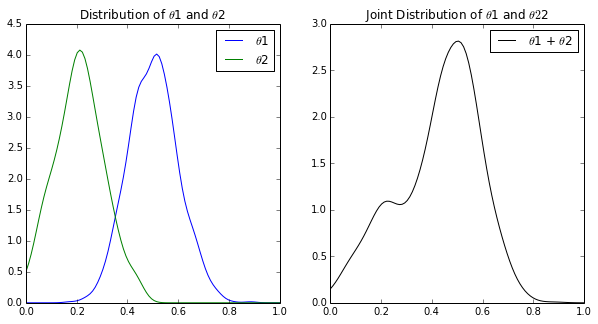

In [94]:
# Density of Plot $\theta$ 1 and 2
## Get x coordinates from 0 to 1
xs = np.linspace(0, 1, num=100)

## Get Density functions
density1 = stats.gaussian_kde(theta1)
density2 = stats.gaussian_kde(theta2)
density = stats.gaussian_kde(theta)

## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(xs, density1(xs), label=r'$\theta$1')
ax1.plot(xs, density2(xs), label=r'$\theta$2')
ax1.set_title(r'Distribution of $\theta$1 and $\theta$2', fontsize=12)
ax1.legend()

ax2.plot(xs, density(xs), color='k', label=r'$\theta$1 + $\theta$2')
ax2.set_title(r'Joint Distribution of $\theta$1 and $\theta2$2', fontsize=12)
ax2.legend()

Now lets look at the distribution of our coverage counts

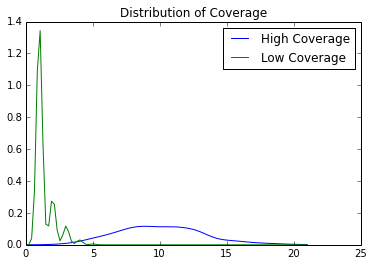

In [105]:
# Plot Distribution of Coverage
## Figure out the x limits
xs = np.linspace(0, cvg.max(), num=100)

## Get Density functions
density1 = stats.gaussian_kde(cvg1)
density2 = stats.gaussian_kde(cvg2)

## Plot
plt.plot(xs, density1(xs), label='High Coverage')
plt.plot(xs, density2(xs), label='Low Coverage')
plt.title('Distribution of Coverage')
plt.legend()

Combine everything into a single dataset.

In [7]:
# Create Data Frame
dat = pd.DataFrame({'theta': theta, 'cvg': cvg})
dat.head(3)

,cvg,theta
0,31,0.549671
1,13,0.486174
2,19,0.564769


In [ ]:
# Plotting Desnsities is a lot easier with data frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
dat['theta'].plot(kind='kde', ax=ax1, title=r'Distribution of $\theta$')
dat['cvg'].plot(kind='kde', ax=ax2, title='Distribution of Coverage')

## QC Time

Now that we have our simulated data, lets do some QC. Lets see what happens if we filter low coverage reads.

First we will create a plotting function that takes a cutoff value.

In [146]:
def pltLow(dat, cutoff):
    """ Function to plot density after filtering"""
    clean = dat[dat['cvg'] >= cutoff]
    clean['theta'].plot(kind='kde', title=r'Distribution of $\theta${}Coverage Count Cutoff $\geq$ {}'.format('\n',cutoff), xlim=(-0.2, 1.2))

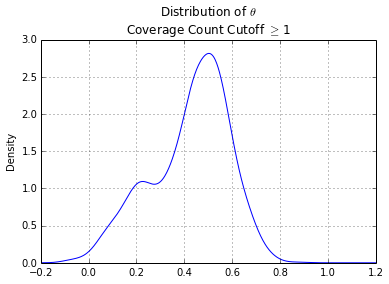

In [147]:
# Test plot function
pltLow(dat, 1)

### Interactive Plotting

Ipython offers a simple way to create interactive plots. You import a function called interact, and use that to call your plotting function.

In [148]:
from IPython.html.widgets import interact, interact_manual, IntSlider, fixed

In [4]:
interact(pltLow, dat=fixed(dat), cutoff=IntSlider(min=0, max=20))

NameError: name 'interact' is not defined

If you have a lot of data, then interact can be slow because at each step along the slider it tries to calculate the filter. There is a noter interactive widget `interact_manual` that only runs calculations when you hit the run button.

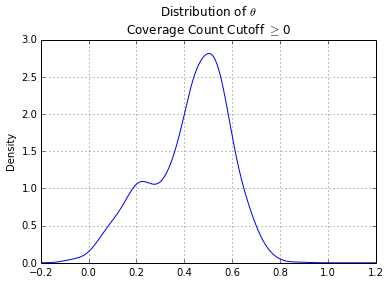

In [150]:
interact_manual(pltLow, dat=fixed(dat), cutoff=IntSlider(min=0, max=20))

## Other types of interactivity

While there are a number of [IPython widgets](http://nbviewer.ipython.org/github/melund/ipython/blob/3.x/examples/Interactive%20Widgets/Index.ipynb) that may be useful, there are other packages that offer interactivity. One I have been playing with is a module that translates matplotlib plots into D3.js plots. I will demonstrate that here.

In [1]:
# Import the mpld3 library
import mpld3

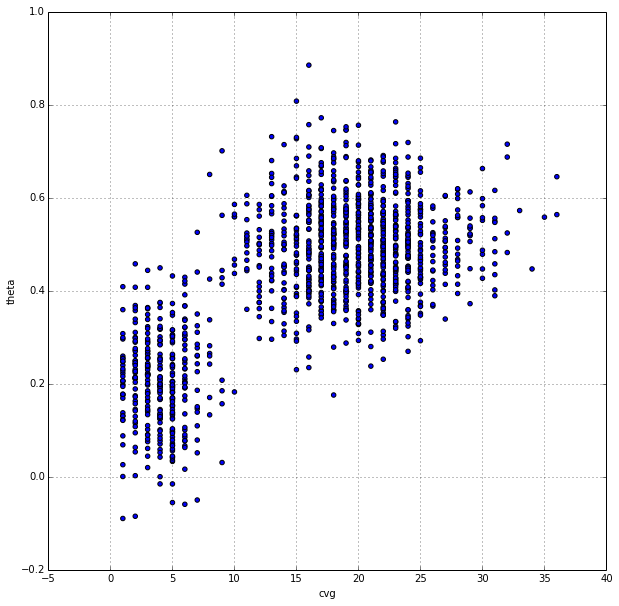

In [10]:
# Plain Scatter plot showing relationship between coverage and theta
dat.plot(kind='scatter', x='cvg', y='theta', figsize=(10, 10))

In [14]:
# Plot figure with mpld3
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(dat['cvg'], dat['theta'])
labels = ['row {}'.format(i) for i in dat.index.tolist()]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

Now lets mess with a point and see if it changes.

In [15]:
dat.ix[262, 'theta'] = -0.1

In [16]:
# Plot figure with mpld3
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(dat['cvg'], dat['theta'])
labels = ['row {}'.format(i) for i in dat.index.tolist()]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()